<a href="https://colab.research.google.com/github/kytk/AI-MAILs/blob/main/python_7_scikit-learn-2.ipynb?hl=ja" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 医療従事者のためのPython: 機械学習 (2)

根本清貴 (筑波大学医学医療系精神医学)

Ver.20240810


### 目次
1. 機械学習とは (復習)
2. 機械学習の適切なモデルの選び方
3. 教師なし学習の概要
4. 主成分分析
5. 乳がんデータセットでの主成分分析
6. k-meansクラスタリング
7. 乳がんデータセットでのk-meansクラスタリング

### 1. 機械学習とは (復習)
- 機械学習の定義
    - 「データからルールやパターンを導き出し、予測や意思決定を行う技術」
    - (従来: 人間がルールを決める)
- 機械学習の種類
    - 教師あり学習
        - 入力データとその対応する正解(ラベル)がペアになったデータセットを用いてモデルを訓練
        - 新しいデータが入ってきた時にそのモデルから正しいラベルを予測
        - 例: 画像の分類(犬と猫の画像を分類)、スパムメールの分類、価格予測
    - 教師なし学習
        - ラベルのないデータを用いてモデルを訓練
        - データの内部構造やパターンを見つけ出す
        - 例: クラスタリング(似たデータをグループに分ける)、次元削減(データの特徴を少数の重要な特徴に圧縮する)
    - 強化学習
        - エージェント(学習者)が環境と相互作用しながら学習する。エージェントは行動を選択し、その結果として得られる報酬を基に次の行動を改善する
        - 長期的な累積報酬を最大化することが目標
        - 例: ゲーム、ロボット制御、自動運転

- 本日は、教師なし学習 (unsupervised learning) について学ぶ


### 2. 機械学習の適切なモデルの選び方

- scikit-learn のホームページにわかりやすい図が示されている
    - https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html
<img src="https://scikit-learn.org/1.3/_static/ml_map.png">
- これを見ると、機械学習を行うには、データは最低50例必要であることがわかる
    - 根拠を探したが見つけられなかった

### 3. 教師なし学習の概要

- データに対する正解ラベルを必要とせず、データの内部構造やパターンを学習する方法
- ラベルのないデータを用いて、データの特性を理解し、データを構造化することが目的

#### 3.1. 教師なし学習の主要な手法

1. **次元削減 (Dimensionality Reduction)**:
   - データの特徴量の次元を減らし、データを簡潔に表現する手法
   - 主なアルゴリズム: 主成分分析 (PCA)、独立成分分析 (ICA)、t-SNEなど
   - **例**: 遺伝子発現解析において、数千の遺伝子データを主成分分析(PCA)で数十の主要パターンに圧縮することで、疾患の特徴や患者群の違いを効率的に可視化する

2. **クラスタリング (Clustering)**:
   - データを似た特徴を持つグループ（クラスター）に分ける手法
   - 主なアルゴリズム: k-means、階層型クラスタリング、DBSCANなど
   - **例**: 患者の血液検査結果を用いて、似た特徴を持つ患者群を自動的に分類する。k-meansアルゴリズムを使用して、例えば3つのクラスターに分けると、「健康な患者群」「代謝異常リスク群」「炎症性疾患リスク群」といった意味のあるグループが形成され、それぞれに適した予防策や治療方針の策定に役立つ
      
3. **異常検知 (Anomaly Detection)**:
   - 正常なデータから外れる異常なデータポイントを検出する手法。
   - 主なアルゴリズム: 一クラスSVM、孤立森林、ガウス混合モデルなど。
   - **例**: 心電図データに孤立森林アルゴリズムを適用することで、通常の心拍パターンから逸脱した不整脈や心臓異常を自動的に検出し、早期診断や緊急対応につなげることができる

- 今回は主成分分析とk-meansクラスタリングを実装する
   


### 4. 主成分分析
- 次元削減のうち、よく用いられている主成分分析をscikit-learnで実装する
- 医療データに応用する前に、わかりやすいように学生の5教科 (5次元) の試験結果を主成分分析で2次元にしてみる

#### 4.1. パッケージのインポート
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn の preprocessingモジュール から 標準化関数 StandardScaler
- Scikit-learn の decompositionモジュール から PCA


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### 4.2. データの読み込み

- student_scores.csv をダウンロード
- Pandas で df として読み込む


In [39]:
# コマンドの前に ! をつけると、Linuxコマンドが動作できる
![[ -f student_scores.csv ]] || wget https://raw.githubusercontent.com/kytk/AI-MAILs/main/data/student_scores.csv

In [40]:
# student_scores.csv を df という名前の Pandasデータフレームとして読み込み
df = pd.read_csv('student_scores.csv')

In [41]:
# データの先頭および最後の5行を表示
# group は science が理系、humanities が文系
print("データセットの先頭5行:")
df.head()


データセットの先頭5行:


,English,Math,Science,Japanese,Social_studies,group
0,78,72,63,60,58,science
1,72,61,65,63,75,science
2,68,57,77,41,63,science
3,87,49,76,72,51,science
4,73,81,74,67,55,science


In [42]:
print("データセットの最後5行:")
df.tail()


データセットの最後5行:


,English,Math,Science,Japanese,Social_studies,group
145,64,72,61,74,61,humanities
146,64,43,69,64,77,humanities
147,87,63,48,49,79,humanities
148,80,63,70,63,50,humanities
149,67,67,50,49,64,humanities


#### 4.3. PandasのDataFrameをNumpyのndarrayに変換

- scikit-learn で扱うデータは基本、NumPy配列
- 前回はサンプルデータを使っているのであまり意識しなかったが、PandasのDataFrameをNumPyに変換する
- Pandas→NumPyは、`to_numpy` メソッドを使うだけなのでとても簡単
- group以外の5教科の点数をNumPy配列に変換する

In [43]:
# dfから 'group' の列だけ drop して、df_scoresとして代入
# df.drop('group', axis=1) で削除できる
df_scores = df.drop('group', axis=1)

# df_scores を確認
df_scores

,English,Math,Science,Japanese,Social_studies
0,78,72,63,60,58
1,72,61,65,63,75
2,68,57,77,41,63
3,87,49,76,72,51
4,73,81,74,67,55
...,...,...,...,...,...
145,64,72,61,74,61
146,64,43,69,64,77
147,87,63,48,49,79
148,80,63,70,63,50


In [44]:
# PandasのDataFrame df_scores を NumPy配列に変換
# to_numpy メソッドを使用
scores = df_scores.to_numpy()

# scores を確認
scores

array([[78, 72, 63, 60, 58],
       [72, 61, 65, 63, 75],
       [68, 57, 77, 41, 63],
       [87, 49, 76, 72, 51],
       [73, 81, 74, 67, 55],
       [64, 52, 54, 60, 48],
       [64, 56, 73, 53, 48],
       [83, 46, 71, 67, 46],
       [60, 91, 62, 56, 75],
       [49, 50, 57, 43, 68],
       [76, 80, 92, 49, 75],
       [68, 81, 68, 47, 53],
       [74, 65, 60, 57, 63],
       [79, 82, 84, 54, 40],
       [71, 54, 67, 63, 40],
       [64, 73, 64, 56, 47],
       [90, 80, 85, 44, 67],
       [55, 62, 57, 51, 73],
       [82, 71, 70, 74, 61],
       [80, 89, 57, 74, 53],
       [52, 54, 62, 65, 53],
       [74, 53, 66, 54, 65],
       [59, 81, 84, 43, 69],
       [70, 64, 78, 75, 52],
       [76, 63, 76, 67, 41],
       [53, 86, 78, 59, 69],
       [55, 86, 69, 72, 40],
       [82, 60, 60, 45, 47],
       [85, 65, 81, 63, 54],
       [76, 83, 72, 51, 41],
       [56, 64, 55, 41, 67],
       [80, 83, 90, 40, 58],
       [51, 84, 79, 45, 71],
       [52, 67, 66, 63, 44],
       [91, 57

#### 4.3. データの前処理: 標準化
- 5教科を 平均値0, 標準偏差1 となるように標準化する
- `StandardScaler()` 関数を使用する

In [45]:
# データの標準化

# StandardScaler() 関数を使用して標準化を行うオブジェクト scaler を生成
scaler = StandardScaler()  
# 標準化するためのパラメータを計算(fit)し、適用(transform)する
scores_standardized = scaler.fit_transform(scores)

# 最初の数行を確認
# scores, scores_scaled は numpy型 なので、scores_scaled[:3] で最初の3行が表示される

# scores
print('scores')
print(scores[:3])

# scores_standardized
print('\nscores_standardized')
print(scores_standardized[:3])


scores
[[78 72 63 60 58]
 [72 61 65 63 75]
 [68 57 77 41 63]]

scores_standardized
[[ 0.5559886   0.70138927 -0.16123898 -0.20539915 -0.45741423]
 [ 0.04224143 -0.14706549  0.00730351  0.01949043  0.8972969 ]
 [-0.30025668 -0.4555945   1.01855845 -1.62969981 -0.05896978]]


In [46]:
# 平均と標準偏差を確認
# axis=0 とすることで、各列における行の平均や標準偏差を求められる
print('\nscoresの平均:', np.round(scores.mean(axis=0),1))
print('scoresの標準偏差:', np.round(scores.std(axis=0),1))

print('\nscores_standardizedの平均:', np.round(scores_standardized.mean(axis=0),1))
print('scores_standardizedの標準偏差:', np.round(scores_standardized.std(axis=0),1))


scoresの平均: [71.5 62.9 64.9 62.7 63.7]
scoresの標準偏差: [11.7 13.  11.9 13.3 12.5]

scores_standardizedの平均: [ 0.  0.  0. -0. -0.]
scores_standardizedの標準偏差: [1. 1. 1. 1. 1.]


#### 4.4. PCAの適用
- Scikit-learn の PCAは非常に簡単
- `PCA()` 関数を使用して PCAを行うオブジェクトを生成する
    - その際、`n_components=2` のように次元を指定する
    - ここでは 2 に設定しているので、データを2次元に圧縮する
    - つまり、元のデータの次元数に関わらず、もっとも重要な2つの主成分だけを保持するようにPCAに指示する
- その後、準備したオブジェクトのメソッド `fit_transform()` にデータを投入するだけ
    - `fit()`: 入力データに基づいてPCAモデルを学習
        - これにより、主成分（固有ベクトル）と、各主成分の重要度（固有値）が計算される
    - `transform()`: 学習したモデルを使って、入力データを新しい主成分空間に変換する
- `scores_pca` は、元のデータを2次元の主成分空間に投影した結果
    - 各行は元のデータに対応し、2つの列はそれぞれ第1主成分と第2主成分の値を意味する



In [47]:
# PCAの適用

# PCAを行うオブジェクト pca を生成
pca = PCA(n_components=2)

# 前処理が終わったデータを投入し、fitで学習、transformで変換
scores_pca = pca.fit_transform(scores_standardized) 

- PCAの結果を確認
    - scores_pcaの形状: `scores_pca.shape`
    - scores_pca の実際の値 `scores_pca`
    - 主成分の方向 (固有ベクトル): `pca.components_`
    - 主成分の分散 (固有値): `pca.explained_variance_`
    - 固有値の寄与率: `pca.explained_variance_ratio_`

In [48]:
# 大きさは150行2列
# 150人の5教科のデータが2つの情報に集約された
print('scoresの形状: ', scores_pca.shape)

scoresの形状:  (150, 2)


In [49]:
# scores_pca そのものを見る
# 各例の第1軸に対する寄与度、第2軸に対する寄与度が示されている
print('scores_pca の実際の値: 5人分\n', scores_pca[:5])

scores_pca の実際の値: 5人分
 [[-0.57401453 -0.55415266]
 [ 0.53348219 -0.11670315]
 [-0.9383904  -0.38364891]
 [-0.07624443 -0.58412138]
 [-1.42996342  0.20866744]]


- `pca.components_`:
   - 固有ベクトル (主成分の方向)を表す行列
   - 各行が主成分(第1主成分、第2主成分)に対応し、列は元の特徴量(教科)に対応


In [50]:
# 固有ベクトルは、各教科の第1軸、第2軸に対するベクトル (あとで図示)

print('固有ベクトル(主成分の方向): \n', pca.components_)

固有ベクトル(主成分の方向): 
 [[ 0.06230819 -0.56476387 -0.54845932  0.36148897  0.49565871]
 [-0.86204352 -0.00274022  0.12926714  0.47946071 -0.10139474]]


- `pca.components_.T`:
   - `.T`は転置を意味
   - 転置することで、各行が元の特徴量(教科)に、各列が主成分(第1主成分、第2主成分)に対応

In [51]:
print('固有ベクトル(主成分の方向)の転置: \n', pca.components_.T)

固有ベクトル(主成分の方向)の転置: 
 [[ 0.06230819 -0.86204352]
 [-0.56476387 -0.00274022]
 [-0.54845932  0.12926714]
 [ 0.36148897  0.47946071]
 [ 0.49565871 -0.10139474]]


- `pca.explained_variance_`:
   - 固有値 (各主成分の分散)
   - 各主成分がデータの全体の分散のうちどれだけを説明しているかを意味

- `np.sqrt(pca.explained_variance_)`:
   - 分散の平方根を取ることで、固有値を標準偏差のスケールに変換



In [52]:
print('固有値(主成分の分散): ', pca.explained_variance_)
print('固有値の標準偏差: ', np.sqrt(pca.explained_variance_))

固有値(主成分の分散):  [1.68912231 1.05883818]
固有値の標準偏差:  [1.29966238 1.02899863]


- `pca.explained_variance_ratio_`:
  - 固有値の寄与率

In [53]:
print('固有値の寄与率: ', pca.explained_variance_ratio_)

固有値の寄与率:  [0.3355723  0.21035585]


- 主成分負荷量
    - 主成分の固有ベクトルに主成分の固有値の標準偏差をかけ合わせたもの
    - 元の特徴量が各主成分にどの程度寄与しているかを示す
    

In [54]:
# 各特徴量（教科）の主成分への寄与度 (主成分負荷量)

# pca.components_ を列で示したいので、.T で転置する
# それに固有値の標準偏差をかけあわせる
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# 結果を表にしたいので、Pandasを使って表にする
# NumPy配列をPandasにするときには、pd.DataFrame(numpy配列, columns=[列名], index=[行名])とする
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df.columns[:-1])


print("\n各特徴量の主成分負荷量:")
print(loadings_df)


各特徴量の主成分負荷量:
                     PC1       PC2
English         0.080980 -0.887042
Math           -0.734002 -0.002820
Science        -0.712812  0.133016
Japanese        0.469814  0.493364
Social_studies  0.644189 -0.104335


- 主成分負荷量からの考察
  - 英語は PC2 の負の方向に大きく寄与している
  - 数学と理科は PC1 の負の方向に寄与している
  - 国語は PC1 と PC2 に同程度寄与している
  - 社会は PC1 の正の方向に寄与している

- 第1主成分は、プラスなら文系、マイナスなら理系ということで、「文理軸」と言えるか
- 第2主成分は、プラスなら国語、マイナスなら英語ということで、「言語軸」と言えるか

#### 4.5. PCAの結果の可視化

##### 4.5.1. 散布図
- scores_pca を横軸 第1主成分 PC1, 縦軸 第2主成分 PC2 の座標にプロット
- 個々の点は個人を示す
- 色は、その人が理系か文系を示す

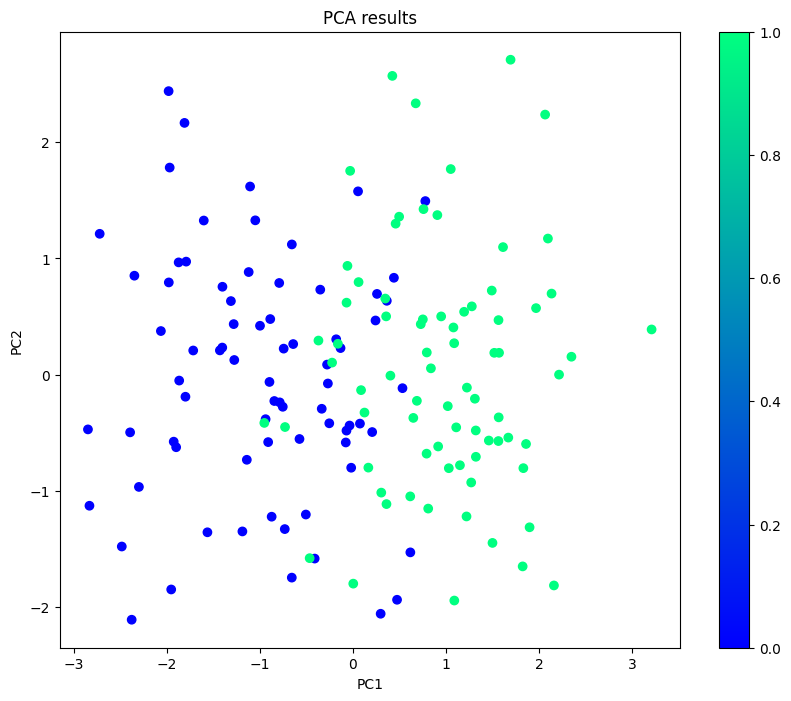

In [55]:
# 散布図にプロット
# 横軸に scores_pcaの第1列、縦軸に scores_pcaの第2列をプロット

# 理系の人を0(青色), 文系の人を1(緑色)で表示

plt.figure(figsize=(10, 8))
scatter = plt.scatter(scores_pca[:, 0], scores_pca[:, 1], 
                      c=df['group'].map({'science': 0, 'humanities': 1}), cmap='winter')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA results')
plt.show()


- 以下のコードで、どの点がどの個人かを同定することもできる

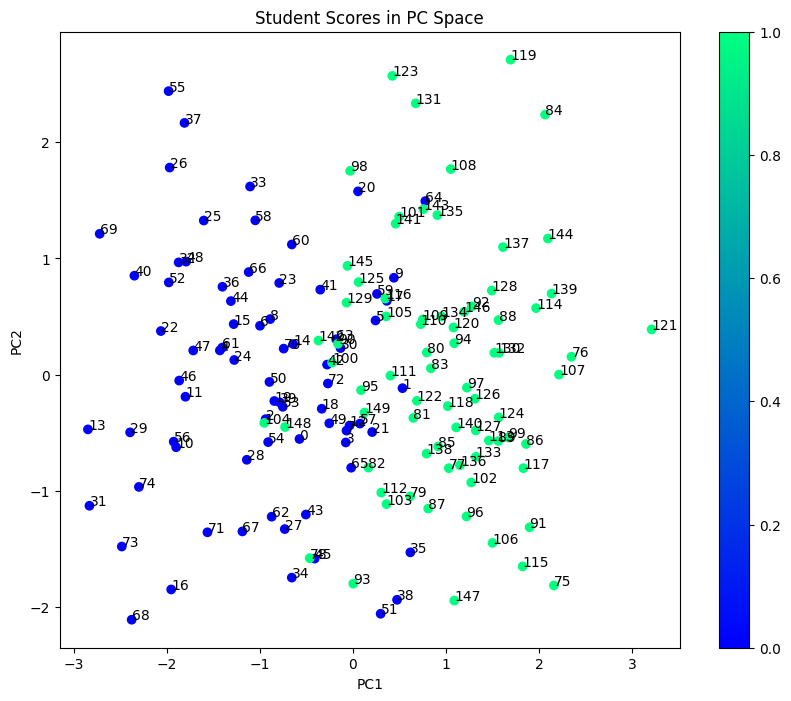

In [56]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(scores_pca[:, 0], scores_pca[:, 1], 
                      c=df['group'].map({'science': 0, 'humanities': 1}), cmap='winter')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Student Scores in PC Space')
for i, txt in enumerate(df.index):
    plt.annotate(txt, (scores_pca[i, 0], scores_pca[i, 1]))
plt.show()

#### 4.5.2. 固有ベクトルの可視化

固有ベクトル:
                     PC1       PC2
English         0.062308 -0.862044
Math           -0.564764 -0.002740
Science        -0.548459  0.129267
Japanese        0.361489  0.479461
Social_studies  0.495659 -0.101395


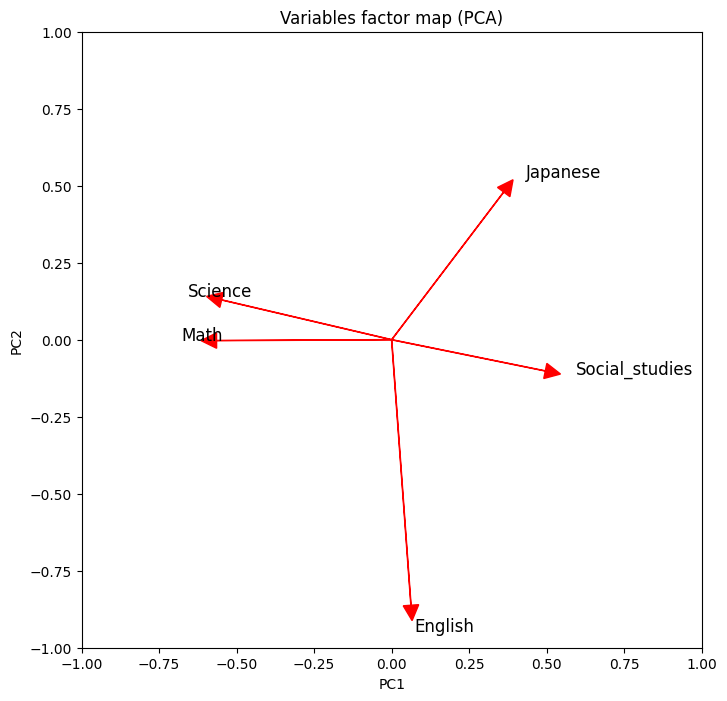

In [57]:
# 固有ベクトルを改めて表示
print("固有ベクトル:")
print(pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df.columns[:-1]))

# 固有ベクトルをプロット
plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, fc='r', ec='r')
    plt.text(x*1.2, y*1.1, df.columns[i], fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Variables factor map (PCA)')
plt.show()

- これから改めて以下が考察される
    - PC1 は文系か理系かを示す。値が正ならば文系、負ならば理系
    - PC2 は言語を示す 値が正ならば国語がより得意、負ならば英語が得意

### 5. 乳がんデータセットを用いた主成分分析
- 乳がんデータセットの30の特徴量を2次元まで削減する
- その2次元がもしかしたら良性・悪性の特徴に近いかもしれないので、その一致度も見てみる

#### 5.0. 乳がんデータセット (復習)
- データセットの名称: Breast Cancer Wisconsin (Diagnostic) dataset
- サンプル数: 569
- 特徴量の数: 30
- ターゲットの種類: 2クラス（良性と悪性）
  - 0: 悪性; 1: 良性
- 特徴量の種類: 実数値


- 細胞診における細胞核の30の特徴量

| 英語 | 日本語 | 英語 | 日本語 |
| --- | --- | --- | --- |
| mean radius | 平均半径 | mean texture | 平均テクスチャ |
| mean perimeter | 平均周囲長 | mean area | 平均面積 |
| mean smoothness | 平均平滑度 | mean compactness | 平均コンパクト度 |
| mean concavity | 平均陥凹度 | mean concave points | 平均陥凹点数 |
| mean symmetry | 平均対称性 | mean fractal dimension | 平均フラクタル次元 |
| radius error | 半径誤差 | texture error | テクスチャ誤差 |
| perimeter error | 周囲長誤差 | area error | 面積誤差 |
| smoothness error | 平滑度誤差 | compactness error | コンパクト度誤差 |
| concavity error | 陥凹度誤差 | concave points error | 陥凹点数誤差 |
| symmetry error | 対称性誤差 | fractal dimension error | フラクタル次元誤差 |
| worst radius | 最悪の半径 | worst texture | 最悪のテクスチャ |
| worst perimeter | 最悪の周囲長 | worst area | 最悪の面積 |
| worst smoothness | 最悪の平滑度 | worst compactness | 最悪のコンパクト度 |
| worst concavity | 最悪の陥凹度 | worst concave points | 最悪の陥凹点数 |
| worst symmetry | 最悪の対称性 | worst fractal dimension | 最悪のフラクタル次元 |


#### 5.1. パッケージのインポート
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn の preprocessingモジュール から 正規化関数 MinMaxScaler
- Scikit-learn の decompositionモジュール から PCA


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#### 5.2. データの読み込み

- 先程と同じように、サンプルデータセットを読み込むのではなく、Excelファイルを Pandas に読み込む
- target は不要のために外す

In [59]:
# コマンドの前に ! をつけると、Linuxコマンドが動作できる
![[ -f breast_cancer_data.xlsx ]] || wget https://raw.githubusercontent.com/kytk/AI-MAILs/main/data/breast_cancer_data.xlsx

- Pandas の DataFrame への読み込み

In [60]:
df = pd.read_excel('breast_cancer_data.xlsx')

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [61]:
# target 列は削除
df_data = df.drop('target', axis=1)

df_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [99]:
# df_data の列名を feature_names とする
feature_names = df_data.columns

feature_names

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [63]:

# NumPy配列に変換
data = df_data.to_numpy()

data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [64]:
# target は target としてnumpyに変換しておく
target = df['target'].to_numpy()

target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

#### 5.3. データの前処理: 正規化
- 30の特徴量に対して正規化 (0-1 に変換)を行う
- 教師あり学習の時と同じ

In [65]:
# データの正規化

# MinMaxScaler() 関数を使用して標準化を行うオブジェクト scaler を生成
scaler = MinMaxScaler()  
# 正規化するためのパラメータを計算(fit)し、適用(transform)する
data_normalized = scaler.fit_transform(data)

# 最初の数行を確認
# data, data_normalized は numpy型 なので、data[:3] で最初の3行が表示される

# data
print('data')
print(np.round(data[:3],1))

# data_normalized
print('\ndata_normalized')
print(np.round(data_normalized[:3],1))


data
[[1.800e+01 1.040e+01 1.228e+02 1.001e+03 1.000e-01 3.000e-01 3.000e-01
  1.000e-01 2.000e-01 1.000e-01 1.100e+00 9.000e-01 8.600e+00 1.534e+02
  0.000e+00 0.000e+00 1.000e-01 0.000e+00 0.000e+00 0.000e+00 2.540e+01
  1.730e+01 1.846e+02 2.019e+03 2.000e-01 7.000e-01 7.000e-01 3.000e-01
  5.000e-01 1.000e-01]
 [2.060e+01 1.780e+01 1.329e+02 1.326e+03 1.000e-01 1.000e-01 1.000e-01
  1.000e-01 2.000e-01 1.000e-01 5.000e-01 7.000e-01 3.400e+00 7.410e+01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.500e+01
  2.340e+01 1.588e+02 1.956e+03 1.000e-01 2.000e-01 2.000e-01 2.000e-01
  3.000e-01 1.000e-01]
 [1.970e+01 2.120e+01 1.300e+02 1.203e+03 1.000e-01 2.000e-01 2.000e-01
  1.000e-01 2.000e-01 1.000e-01 7.000e-01 8.000e-01 4.600e+00 9.400e+01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.360e+01
  2.550e+01 1.525e+02 1.709e+03 1.000e-01 4.000e-01 5.000e-01 2.000e-01
  4.000e-01 1.000e-01]]

data_normalized
[[0.5 0.  0.5 0.4 0.6 0.8 0.7 0.7 0.7 0.6 0.

#### 5.4. PCAの適用

- `PCA()` 関数を使用して PCAを行うオブジェクトを生成する
  - `n_components` で 圧縮する次元を指定する
- その後、準備したオブジェクトのメソッド `fit_transform()` にデータを投入する
    - `fit()`: 入力データに基づいてPCAモデルを学習
        - これにより、主成分（固有ベクトル）と、各主成分の重要度（固有値）が計算される
    - `transform()`: 学習したモデルを使って、入力データを新しい主成分空間に変換する
- `scores_pca` は、元のデータを2次元の主成分空間に投影した結果
    - 各行は元のデータに対応し、2つの列はそれぞれ第1主成分と第2主成分の値を意味する



In [66]:
# PCAの適用

# PCAを行うオブジェクト pca を生成
pca = PCA(n_components=2)

# 前処理が終わったデータを投入し、fitで学習、transformで変換
data_pca = pca.fit_transform(data_normalized) 

- PCAの結果を確認
    - data_pcaの形状: `data_pca.shape`
    - data_pca の実際の値 `data_pca`
    - 主成分の方向 (固有ベクトル): `pca.components_`
    - 主成分の分散 (固有値): `pca.explained_variance_`
    - 固有値の寄与率: `pca.explained_variance_ratio_`

In [67]:
# data_pca の形状
# 569行2列
data_pca.shape

(569, 2)

In [68]:
# data_pca そのもの
# 小数点2位で丸め

np.round(data_pca,2)

array([[ 1.39,  0.43],
       [ 0.46, -0.56],
       [ 0.95, -0.11],
       ...,
       [ 0.23, -0.29],
       [ 1.68,  0.34],
       [-0.91, -0.1 ]])

In [69]:
# 固有ベクトル

np.round(pca.components_.T,2)

array([[ 0.24, -0.26],
       [ 0.1 , -0.06],
       [ 0.25, -0.24],
       [ 0.22, -0.23],
       [ 0.11,  0.2 ],
       [ 0.24,  0.21],
       [ 0.3 ,  0.11],
       [ 0.32, -0.01],
       [ 0.11,  0.21],
       [ 0.04,  0.41],
       [ 0.12, -0.07],
       [-0.  ,  0.06],
       [ 0.12, -0.05],
       [ 0.1 , -0.08],
       [-0.  ,  0.14],
       [ 0.13,  0.22],
       [ 0.07,  0.1 ],
       [ 0.12,  0.11],
       [ 0.01,  0.14],
       [ 0.05,  0.17],
       [ 0.26, -0.24],
       [ 0.11, -0.04],
       [ 0.26, -0.21],
       [ 0.21, -0.2 ],
       [ 0.12,  0.23],
       [ 0.2 ,  0.2 ],
       [ 0.24,  0.15],
       [ 0.37,  0.04],
       [ 0.1 ,  0.15],
       [ 0.09,  0.26]])

In [70]:
# 固有値の標準偏差

np.sqrt(pca.explained_variance_)

array([0.5756161 , 0.32840581])

In [71]:
# 固有値の寄与率
pca.explained_variance_ratio_

array([0.53097689, 0.1728349 ])

In [72]:
# 主成分負荷量

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

np.round(loadings,2)

array([[ 0.14, -0.09],
       [ 0.06, -0.02],
       [ 0.15, -0.08],
       [ 0.12, -0.08],
       [ 0.06,  0.07],
       [ 0.14,  0.07],
       [ 0.17,  0.04],
       [ 0.19, -0.  ],
       [ 0.06,  0.07],
       [ 0.02,  0.13],
       [ 0.07, -0.02],
       [-0.  ,  0.02],
       [ 0.07, -0.02],
       [ 0.06, -0.03],
       [-0.  ,  0.04],
       [ 0.07,  0.07],
       [ 0.04,  0.03],
       [ 0.07,  0.03],
       [ 0.01,  0.05],
       [ 0.03,  0.06],
       [ 0.15, -0.08],
       [ 0.07, -0.01],
       [ 0.15, -0.07],
       [ 0.12, -0.07],
       [ 0.07,  0.08],
       [ 0.12,  0.07],
       [ 0.14,  0.05],
       [ 0.21,  0.01],
       [ 0.06,  0.05],
       [ 0.05,  0.08]])

- 特徴量が多いと、主成分が何を意味するかすぐに把握しづらい
- こういう時に視覚化が役立つ

### 5.5. PCAの結果の視覚化

#### 5.5.1. 散布図

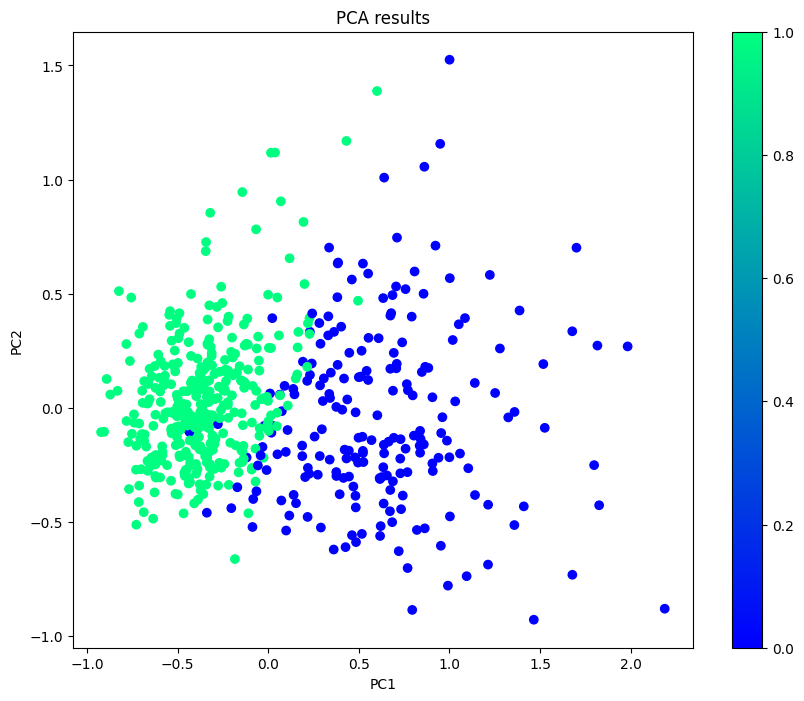

In [73]:
# 散布図にプロット
# 横軸に data_pcaの第1列、縦軸に data_pcaの第2列をプロット

# 悪性を0(青色), 良性を1(緑色)で表示

plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], 
                      c=target, cmap='winter')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA results')
plt.show()


#### 5.5.2. 各特徴量の寄与度

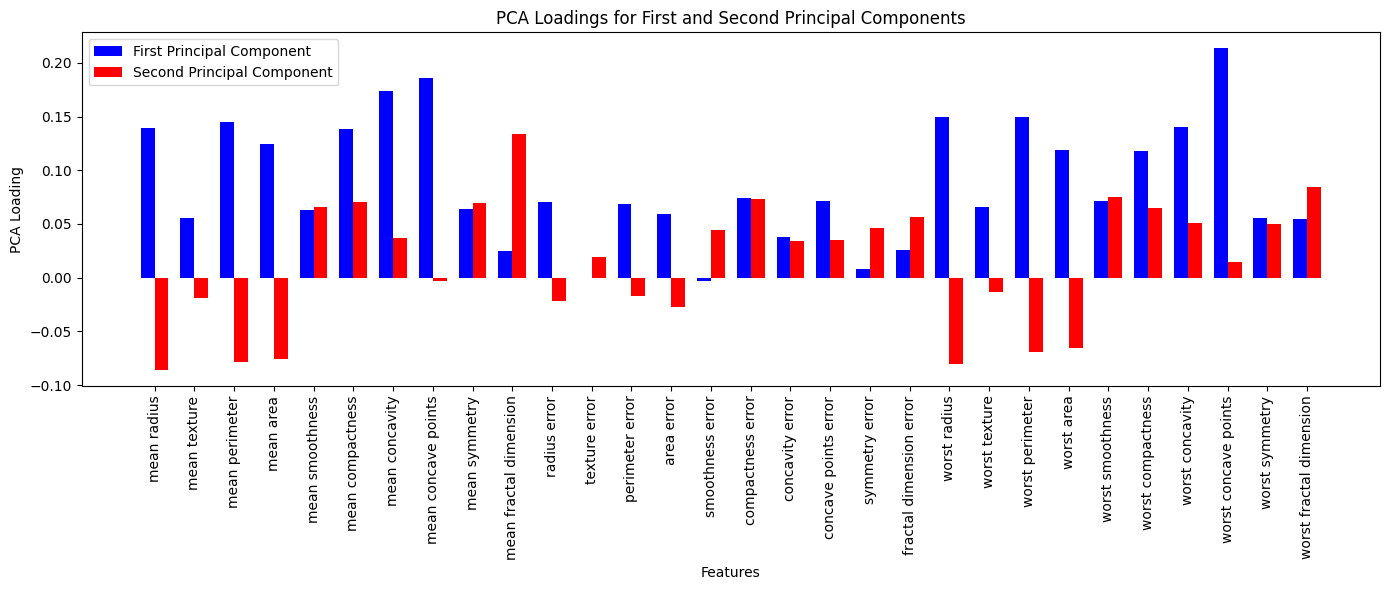

In [74]:
# 特徴量の寄与度
plt.figure(figsize=(14, 6))

# バーの幅と位置の設定
bar_width = 0.35
r1 = np.arange(len(feature_names))
r2 = [x + bar_width for x in r1]

# 2つの主成分のloadingsを少しずらして表示
plt.bar(r1, loadings[:, 0], color='blue', width=bar_width, label='First Principal Component')
plt.bar(r2, loadings[:, 1], color='red', width=bar_width, label='Second Principal Component')

plt.xlabel('Features')
plt.ylabel('PCA Loading')
plt.title('PCA Loadings for First and Second Principal Components')
plt.xticks([r + bar_width/2 for r in range(len(feature_names))], feature_names, rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

- これらの結果から、以下が推測できる
  - 第1主成分が良性か悪性かの軸
    - 第1主成分の負荷量を見ることで、より重要な特徴量が見えてくる
  - 第2主成分の寄与率は少ない


### 6. k-means クラスタリング
- k-means クラスタリングは、教師なし学習の中でも最も基本的でよく使われる手法の一つ
- データセットを \( k \) 個のクラスターに分割し、各データポイントが最も近いクラスタの中心 (セントロイド) に割り当てられる

- アルゴリズムの手順
   1. 初期化
      - クラスタ数 \( k \) を決定し、データポイントからランダムに \( k \) 個のセントロイドを選ぶ
   2. 割り当て
      - 各データポイントを最も近いセントロイドに割り当てる
   3. セントロイドの更新
      - 各クラスタのセントロイドを、クラスタ内のデータポイントの平均値に更新する
   4. 収束
      - セントロイドの位置が変わらなくなるまで、割り当てと更新を繰り返す

- 評価
   - クラスタリングの質を評価するために、内部評価指標（例: シルエットスコア、クラス内分散の総和）を使用する


#### 6.1. パッケージのインポート

- NumPy
- Matplotlib
- Seaborn
- Scikit-learn の preprocessing モジュールから StandardScaler
- Scikit-learn の cluster モジュールから KMeans
- Scikit-learn の metrics モジュールから silhouette_score

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### 6.1. データの読み込み
- scikit-learnには、クラスターを作ってくれる関数 `make_blobs` があるので、それを利用して3つのクラスターのデータを作成する

In [76]:
from sklearn.datasets import make_blobs

# データの生成
n_samples = 120
n_clusters = 3
scores, y = make_blobs(n_samples=n_samples, centers=n_clusters, random_state=10)
scores += 70

In [77]:
# 2つの教科の試験結果　をイメージ
np.round(scores,0)

array([[75., 60.],
       [71., 65.],
       [73., 73.],
       [69., 66.],
       [75., 61.],
       [74., 76.],
       [71., 64.],
       [74., 75.],
       [71., 65.],
       [72., 75.],
       [74., 72.],
       [77., 61.],
       [70., 64.],
       [72., 74.],
       [73., 76.],
       [77., 60.],
       [72., 75.],
       [69., 63.],
       [70., 65.],
       [70., 66.],
       [76., 61.],
       [73., 73.],
       [71., 75.],
       [73., 75.],
       [76., 63.],
       [77., 59.],
       [73., 75.],
       [69., 64.],
       [73., 76.],
       [73., 74.],
       [71., 64.],
       [75., 61.],
       [69., 64.],
       [76., 61.],
       [70., 66.],
       [72., 76.],
       [76., 63.],
       [76., 60.],
       [76., 60.],
       [69., 65.],
       [74., 61.],
       [72., 75.],
       [76., 59.],
       [72., 75.],
       [76., 60.],
       [68., 63.],
       [75., 60.],
       [70., 64.],
       [74., 75.],
       [71., 63.],
       [71., 65.],
       [73., 77.],
       [68.,

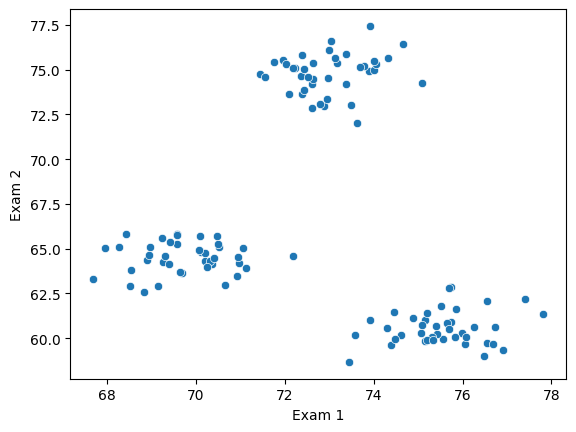

In [78]:
sns.scatterplot(x=scores[:,0], y=scores[:,1])
plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.show()

- 明らかに3つのクラスタに分かれそう
- 3つのクラスタに分けてみる
  - クラスタの推測法は後述

#### 6.2. データの前処理: 標準化

- データの前処理を行う
- これまでと同様、StandardScaler 関数を使って標準化を行う

In [79]:
scaler = StandardScaler()
scores_standardized = scaler.fit_transform(scores)


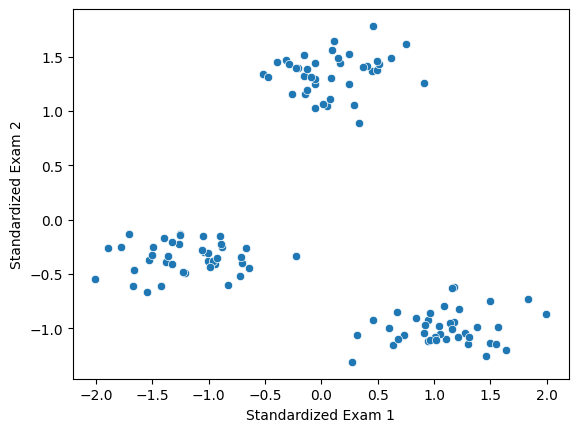

In [80]:
# 標準化後のプロット
sns.scatterplot(x=scores_standardized[:,0], y=scores_standardized[:,1])
plt.xlabel('Standardized Exam 1')
plt.ylabel('Standardized Exam 2')
plt.show()


### 6.3. K-meansクラスタリング

- K-means クラスタリングでは、まず、自分で「いくつのクラスターに分類するか」を決める
- そのクラスターの数で分類器を作成する
- あとは、fit_predict で学習し、予測させる

In [81]:

# K-means クラスタリングの実行
# クラスターの数を定義
n_clusters = 3

# KMeans関数で kmeans オブジェクトを生成
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# データを入れて学習させる
clusters = kmeans.fit_predict(scores_standardized)


- kmeansオブジェクトの属性から情報を抽出する
  - `cluster_centers_`: クラスタの中心 (セントロイド) の座標
  - `labels_`: 各データがどれに分類されたかを含む配列
  - `inertia_`: クラスタ内のデータとデータの中心の距離の二乗の総和
    - inertia_ が小さいほど、各データがそのクラスタの中心に近いことを意味

In [82]:
# セントロイドの座標
kmeans.cluster_centers_

array([[ 1.0929019 , -0.99566937],
       [ 0.09058838,  1.34498113],
       [-1.18349027, -0.34931176]])

In [83]:
# クラスタリングで分類された結果
# 上の clusters と同じ内容
kmeans.labels_

array([0, 2, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 1,
       0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 1, 2,
       0, 0, 1, 2, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 2, 1, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 2, 0, 2,
       1, 0, 0, 0, 1, 0, 2, 2, 0, 1], dtype=int32)

In [84]:
# 各クラスターに所属するデータとクラスター中心の距離の二乗の総和
kmeans.inertia_

18.97438109835684

- シルエットスコアを計算する。シルエットスコアは -1から1 の範囲で、高いほどよいクラスタリングを示す

In [85]:
# シルエットスコアを計算
silhouette = silhouette_score(scores_standardized, clusters)

print(f'シルエットスコア: {silhouette: .2f}')

シルエットスコア:  0.77


#### 6.4. 結果の可視化

- 各クラスタを色分けし、クラスタ中心を X で示す

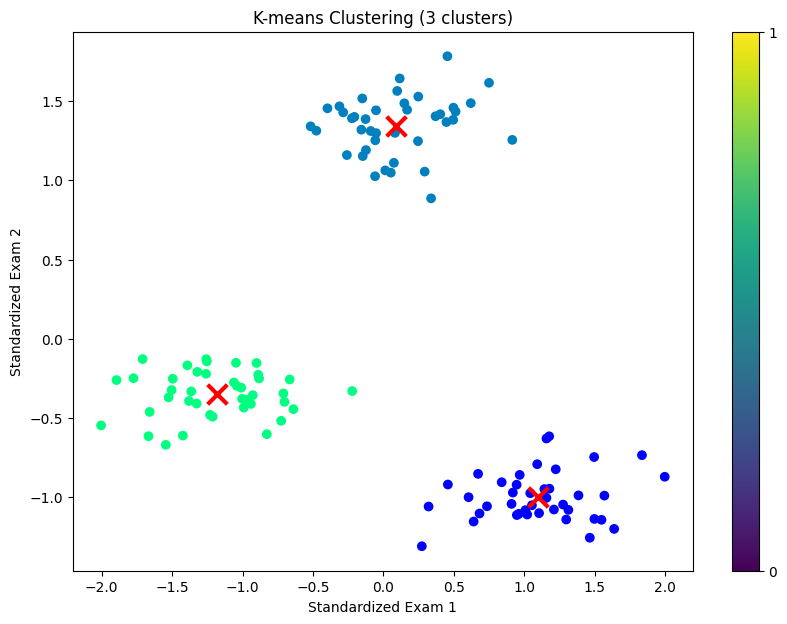

In [86]:

# 結果の可視化
plt.figure(figsize=(10, 7))
plt.scatter(scores_standardized[:, 0], scores_standardized[:, 1], c=kmeans.labels_, cmap='winter')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            marker='x', s=200, linewidths=3, color='r', zorder=10)
plt.title('K-means Clustering (3 clusters)')
plt.xlabel('Standardized Exam 1')
plt.ylabel('Standardized Exam 2')
plt.colorbar(ticks=range(n_clusters))
plt.show()


#### 6.5. クラスター数の設定

- 上の例ではクラスター数は 3 であることが自明だが、そうはうまくいかない場合もままある
- その時に、クラスター数を1ずつ増やし、kmeans.inertia_を計算し、その推移を観察する
- グラフはたいていの場合、急激に減少した後に緩やかになる"肘 elbow"の形状となる
- この肘の位置が適切なクラスタ数である可能性があり、これをエルボー法という

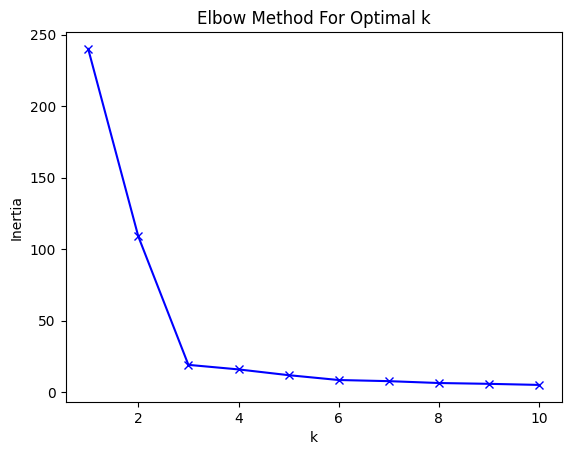

In [87]:
# エルボー法による適切なクラスター数の探索
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scores_standardized)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### 7. 乳がんデータセットによるk-meansクラスタリング

- 乳がんデータセットは良性・悪性がわかっている
- 2つのクラスターにわけられるかトライする

#### 7.1. パッケージのインポート


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


#### 7.2. データの読み込みと前処理
- 今日の前半で使用した breast_cancer_data.xlsx を読み込む
- 正規化を行う

In [89]:
df = pd.read_excel('breast_cancer_data.xlsx')

# target 列は削除
df_data = df.drop('target', axis=1)

# df_data の列名を 取り出したものを feature_names とする
feature_names = df_data.columns

# NumPy配列に変換
data = df_data.to_numpy()

# target は target としてnumpyに変換しておく
target = df['target'].to_numpy()

# データの正規化

# MinMaxScaler() 関数を使用して標準化を行うオブジェクト scaler を生成
scaler = MinMaxScaler()  
# 正規化するためのパラメータを計算(fit)し、適用(transform)する
data_normalized = scaler.fit_transform(data)

In [90]:
feature_names

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

#### 7.3. k-means クラスタリングの適用
- KMeans() 関数に、自分が分類したいクラスター数を指定し、kmeans という分類器を生成する
- 今は、良性と悪性で2つのクラスターができるはずという思いから、2 とする
- `kmeans.fit_predict()` で実際の分類を行う
- シルエットスコアを計算する。シルエットスコアは -1から1 の範囲で、高いほどよいクラスタリングを示す

In [91]:
# KMeans() を使って分類器のオブジェクトを生成
kmeans = KMeans(n_clusters=2, random_state=42)

# 実際にデータを入れて分類
clusters = kmeans.fit_predict(data_normalized)

# シルエットスコアを計算
silhouette = silhouette_score(data_normalized, clusters)

print(f'シルエットスコア: {silhouette: .2f}')

シルエットスコア:  0.38


#### 7.4. 元の特徴量の寄与度を調べる

##### 7.4.1. クラスターの中心と特徴量の関係を調べる
- 以下の関数でクラスターの中心と特徴量の関係をグラフにできる

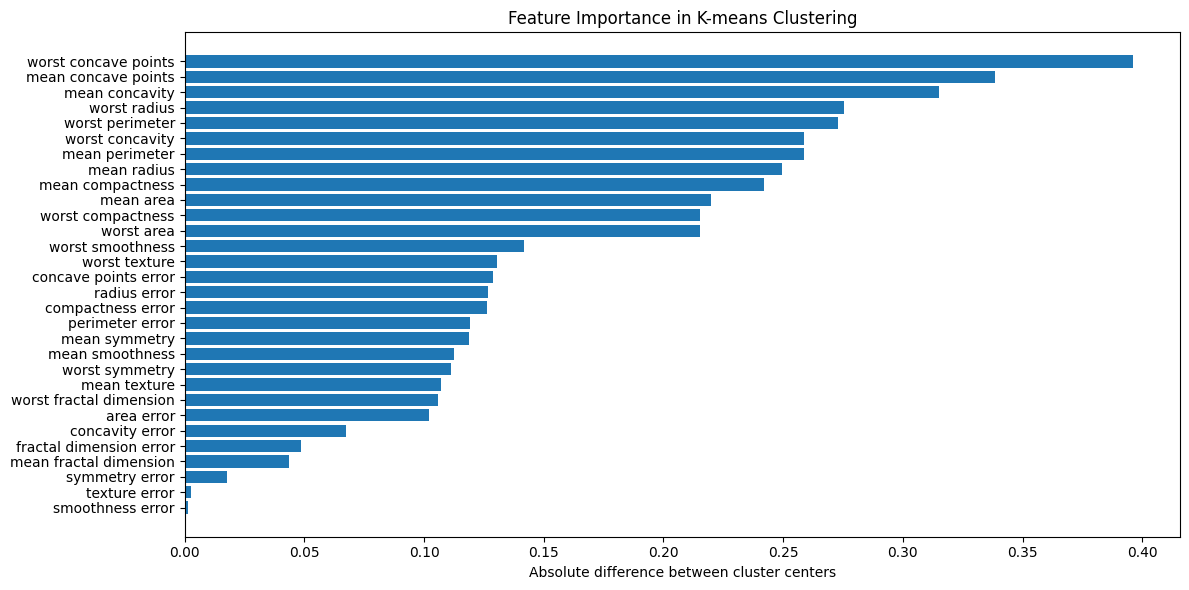

In [92]:
def plot_cluster_centers(kmeans, feature_names):
    centers = kmeans.cluster_centers_
    feature_importance = np.abs(centers[0] - centers[1])
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.xlabel('Absolute difference between cluster centers')
    plt.title('Feature Importance in K-means Clustering')
    plt.tight_layout()
    plt.show()

plot_cluster_centers(kmeans, feature_names)

- kmeans.cluster_centers_ を改めて見てみる

In [93]:
# この配列の形状を確認する

kmeans.cluster_centers_.shape

(2, 30)

In [94]:
np.round(kmeans.cluster_centers_,1)

array([[0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.4, 0.5, 0.5, 0.3, 0.2, 0.2, 0.2,
        0.1, 0.2, 0.3, 0.1, 0.3, 0.2, 0.1, 0.5, 0.5, 0.5, 0.3, 0.5, 0.4,
        0.4, 0.7, 0.3, 0.3],
       [0.3, 0.3, 0.2, 0.1, 0.4, 0.2, 0.1, 0.1, 0.3, 0.3, 0.1, 0.2, 0.1,
        0. , 0.2, 0.1, 0.1, 0.2, 0.2, 0.1, 0.2, 0.3, 0.2, 0.1, 0.4, 0.1,
        0.1, 0.3, 0.2, 0.2]])

- これは、特徴量ごとの、クラスター1とクラスター2の中心を示している
- ある特徴量において、クラスター1とクラスター2の中心の距離が離れていたら、それは、その特徴量はクラスターを分けるのに大きく寄与しているということになる
- 今の場合、"concavity" と "perimeter" あたりのパラメーターが大きく寄与している
- "mean concavity" と "mean perimeter" のふたつでグラフを描いてみる

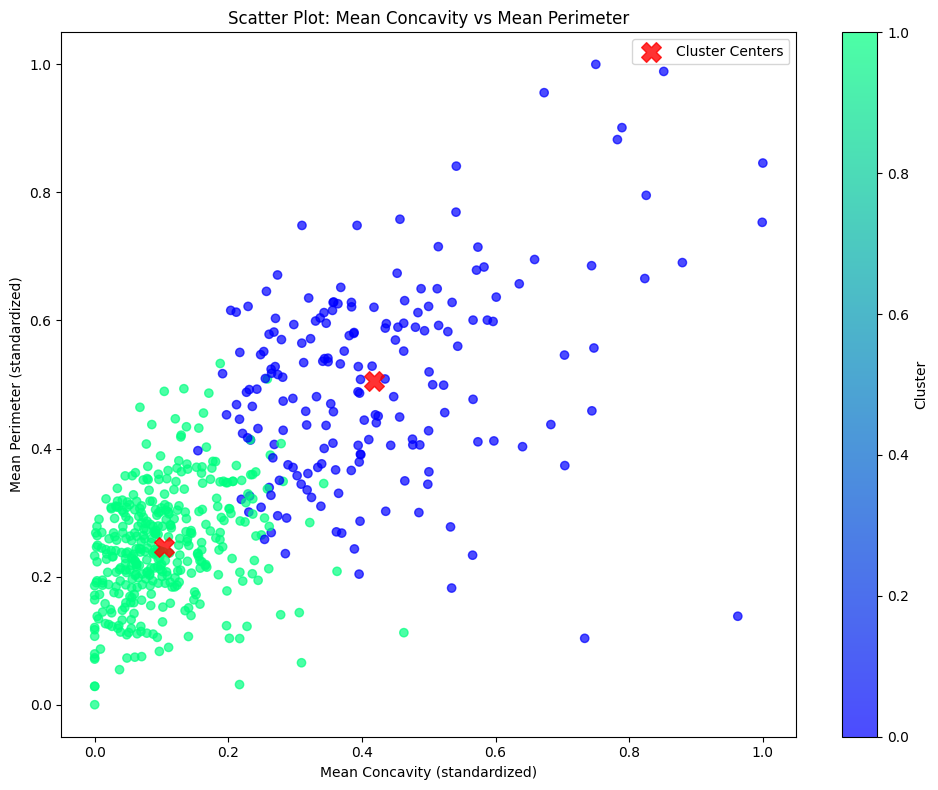

Cluster 0:
  Mean Concavity: 0.4184
  Mean Perimeter: 0.5058
  Number of points: 189

Cluster 1:
  Mean Concavity: 0.1034
  Mean Perimeter: 0.2470
  Number of points: 380



In [95]:
# 'mean concavity' と 'mean perimeter' のインデックスを取得
concavity_idx = np.where(feature_names == 'mean concavity')[0][0]
perimeter_idx = np.where(feature_names == 'mean perimeter')[0][0]

# 散布図の作成
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_normalized[:, concavity_idx], data_normalized[:, perimeter_idx], 
                      c=kmeans.labels_, cmap='winter', alpha=0.7)
plt.xlabel('Mean Concavity (standardized)')
plt.ylabel('Mean Perimeter (standardized)')
plt.title('Scatter Plot: Mean Concavity vs Mean Perimeter')

# クラスターの中心をプロット
centers = kmeans.cluster_centers_
plt.scatter(centers[:, concavity_idx], centers[:, perimeter_idx], 
            c='red', s=200, alpha=0.8, marker='X', label='Cluster Centers')

plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# クラスターごとの統計情報を表示
for i in range(2):
    cluster_points = data_normalized[kmeans.labels_ == i]
    print(f"Cluster {i}:")
    print(f"  Mean Concavity: {np.mean(cluster_points[:, concavity_idx]):.4f}")
    print(f"  Mean Perimeter: {np.mean(cluster_points[:, perimeter_idx]):.4f}")
    print(f"  Number of points: {len(cluster_points)}")
    print()

#### 7.5. 良性、悪性とクラスター分割の一致
- kmeans クラスタリングの結果と良性、悪性の診断がどの程度一致するかを見てみる
- kmeans クラスタリングはあくまでもクラスタリングであり、良性、悪性にわけるためのものではないことに注意
- 混同行列を使用する

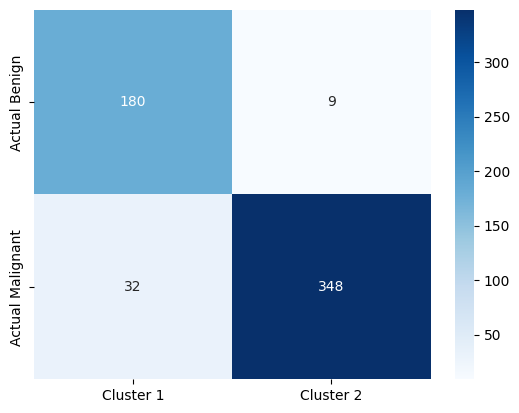

In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score

conf_matrix = confusion_matrix(clusters, target)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cluster 1', 'Cluster 2'], 
            yticklabels=['Actual Benign', 'Actual Malignant'])
plt.show()


In [97]:
test_accuracy = accuracy_score(target, clusters)
print(f'Test Accuracy: {test_accuracy: .2f}')


Test Accuracy:  0.93


#### 7.6. 乳がんデータセットのクラスター数の探索

- 乳がんデータセットは良性か悪性かの2つに分かれているが、実際はクラスターはもう少しあるかもしれない
- エルボー法で探索してみる

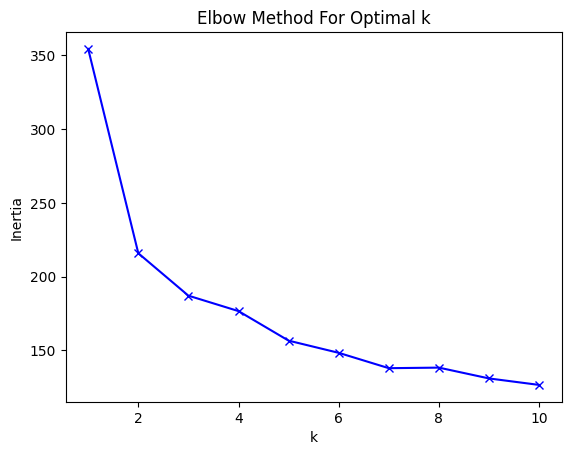

In [101]:
# エルボー法による適切なクラスター数の探索
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

- 2 or 3 程度と考えられる

### おわりに
- 以上、Pythonを使った医療データの解析の基本を一通りカバーしました
  - Pythonの基礎
  - Pandas, NumPy, Seaborn, Matplotlib
  - 機械学習
  - 深層学習
- 私自身、学びながらのところもたくさんありましたが、基本をおさえることで、応用しやすくなると思いますので、少しでもこのような領域に興味・関心を持っていただけたら準備した甲斐があります
- 様々なご意見もありがとうございました。最後の感想もぜひお聞かせください


##### (参考) 主成分分析で使用したデータの生成方法

- 150人の仮想の試験結果を生成
- 理系科目が得意な75人と文系科目が得意な75人を想定
- 5教科 (英語、数学、理科、国語、社会) を乱数で40-75点で生成
- 全員に対して、英語は乱数で5-20点をかさ増し
- 理系科目が得意な75人に対して、数学、理科を5-20点かさ増し
- 文系科目が得意な75人に対して、国語、社会を5-20点かさ増し



In [98]:
# 主成分分析で使用したテストの成績の生成

# 乱数のシードを設定して再現性を確保
np.random.seed(42)

# 初期化
scores = []

# 生徒の数
n_students = 150

# 理系群と文系群の生徒数（ほぼ半々に）
# 理系群は生徒の数を2で割った時の商
# 文系群は 全生徒の数 - 理系生徒の数
n_science = n_students // 2
n_humanities = n_students - n_science

# 基本的な成績の生成（全科目）
scores = np.random.randint(40, 76, size=(n_students, 5))

# 英語の成績調整
scores[:, 0] += np.random.randint(5, 20, n_students)

# 理系群の成績調整
scores[:n_science, 1] += np.random.randint(5, 20, n_science)  # 数学
scores[:n_science, 2] += np.random.randint(5, 20, n_science)  # 理科

# 文系群の成績調整
scores[n_science:, 3] += np.random.randint(5, 20, n_humanities)  # 国語
scores[n_science:, 4] += np.random.randint(5, 20, n_humanities)  # 社会

# データフレームの作成
df = pd.DataFrame(scores, columns=['English', 'Math', 'Science', 'Japanese', 'Social_studies'])

# 実際の群（理系/文系）のラベルを追加
df['group'] = ['science' if i < n_science else 'humanities' for i in range(n_students)]

# データの保存
df.to_csv('student_scores.csv', index=False)